# A Guide to Deep Learning with Keras

In this tutorial, we will introduce how to set up a deep learning pipeline using the Keras API for Python. In particular, you will learn how to use Keras to prune and pre-process datasets, define and create models, and finally visualize our model for accurate classfication. But before we begin, you may be asking yourself why you should learn Keras.

## Why Keras

Keras is a high level deep learning API for Python, which acts as a wrapper on top of TensorFlow and Theano. At the cost of losing low-level functionality such as creating queues for asynchronous processing and specialized debuggers, Keras provides a simple, easy to use interface for setting up layers and training our model. For deep-learning beginners, Keras will make the process of creating models more intuitive and natural as we will shortly see. However, if you are already familiar with TensorFlow or Theano, don't stop reading just yet! Keras was officially designated as the high-level API for TensorFlow allowing Keras code and TensorFlow code to run interchangeably. As a result, many verbose aspects of creating models in TensorFlow can be substituted with short and clean Keras code without sacrificing efficiency or functionality. Sounds like a win-win!

So let's get right into it.

## Setting up your environment

Before installing Keras, you will first need to install one of its backend engines - either TensorFlow or Theano. For the purpose of this tutorial, we will be using TensorFlow. 

You can install TensorFlow on your system with pip using the following command. 

pip install tensorflow

Now, we can install Keras the same way.

pip install keras

We can now import the modules we need in the following way.

In [2]:
import keras
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

/Users/aranade/miniconda2/envs/myapp3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/aranade/miniconda2/envs/myapp3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


## Example 1 - Predicting Consumer Churn

### Data Collection

For this part of the tutorial, we will be using the IBM Watson Telco Dataset (available here - https://www.ibm.com/communities/analytics/watson-analytics-blog/predictive-insights-in-the-telco-customer-churn-data-set/) to predict Customer Churn to understand how Keras can be used to process tabular data. First, we will read our data from the csv file provided using Pandas.



In [3]:
telco_dataset = pd.read_csv("Watson_Telco.csv")
telco_dataset[1:10]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


As you can see, each example has 20 features which we will use to predict the Churn feature. But first, we need to prune our dataset by converting values to the correct type and removing NAN instances. We notice that numeric features like tenure, MonthlyCharges, TotalCharges are strings instead of integers, so we convert them to int type and also drop customerID since it is unique for each customer thereby providing no signal about Churn. 

In [4]:
numeric_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

for header in numeric_cols:
    telco_dataset[header] = pd.to_numeric(telco_dataset[header], errors = 'coerce').fillna(0)
    
telco_dataset = telco_dataset.drop('customerID', axis = 1)
    

### Dataset Pre-Processing

The next step in our Deep Learning pipeline is pre-processing. We need to conduct some data exploration to understand what features need to be pre-processed in order to improve accuracy of our results. First, we notice that there is a bias in our "TotalCharges" data towards smaller values which can be seen below where we plot a histogram of "tenure" with 100 bins. 


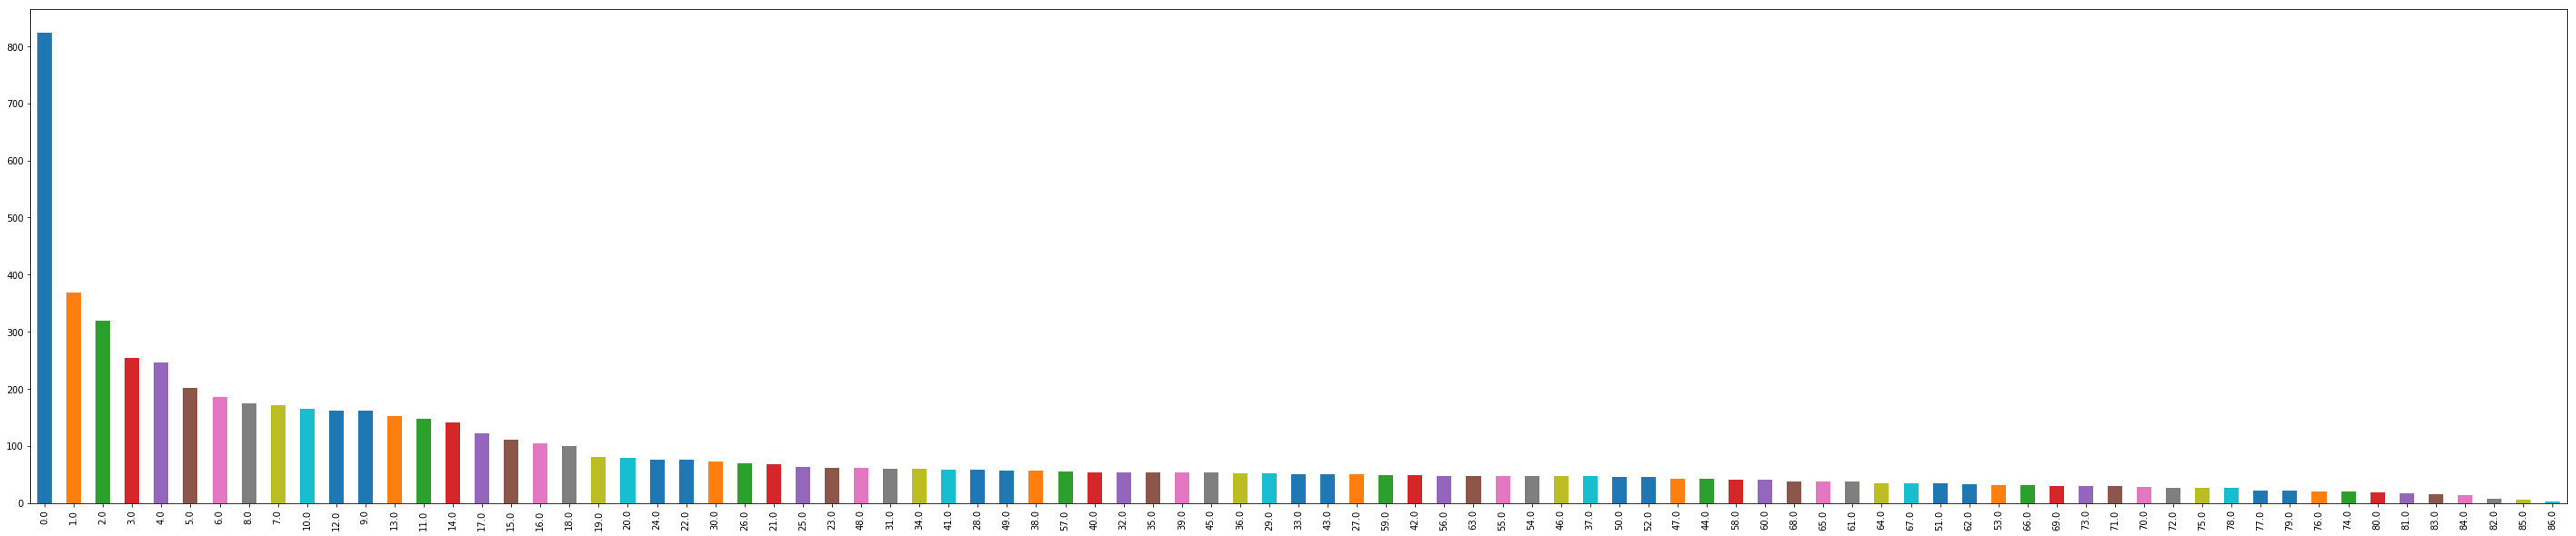

In [5]:
fig = plt.subplots()
a = telco_dataset['TotalCharges'].apply(lambda x: x // 100) 

# plot count of each value
a.sort_values(ascending = True).value_counts().plot(kind="bar", figsize = (50, 10))


We can convert this distribution to look more like a normal distribution by making the following transformation. 
   x -> log(x). We apply this transformation using the .apply function which applies a lambda function to all rows in the feature column.
  
Plotting this new distribution, we see that the bias has reduced significantly. 


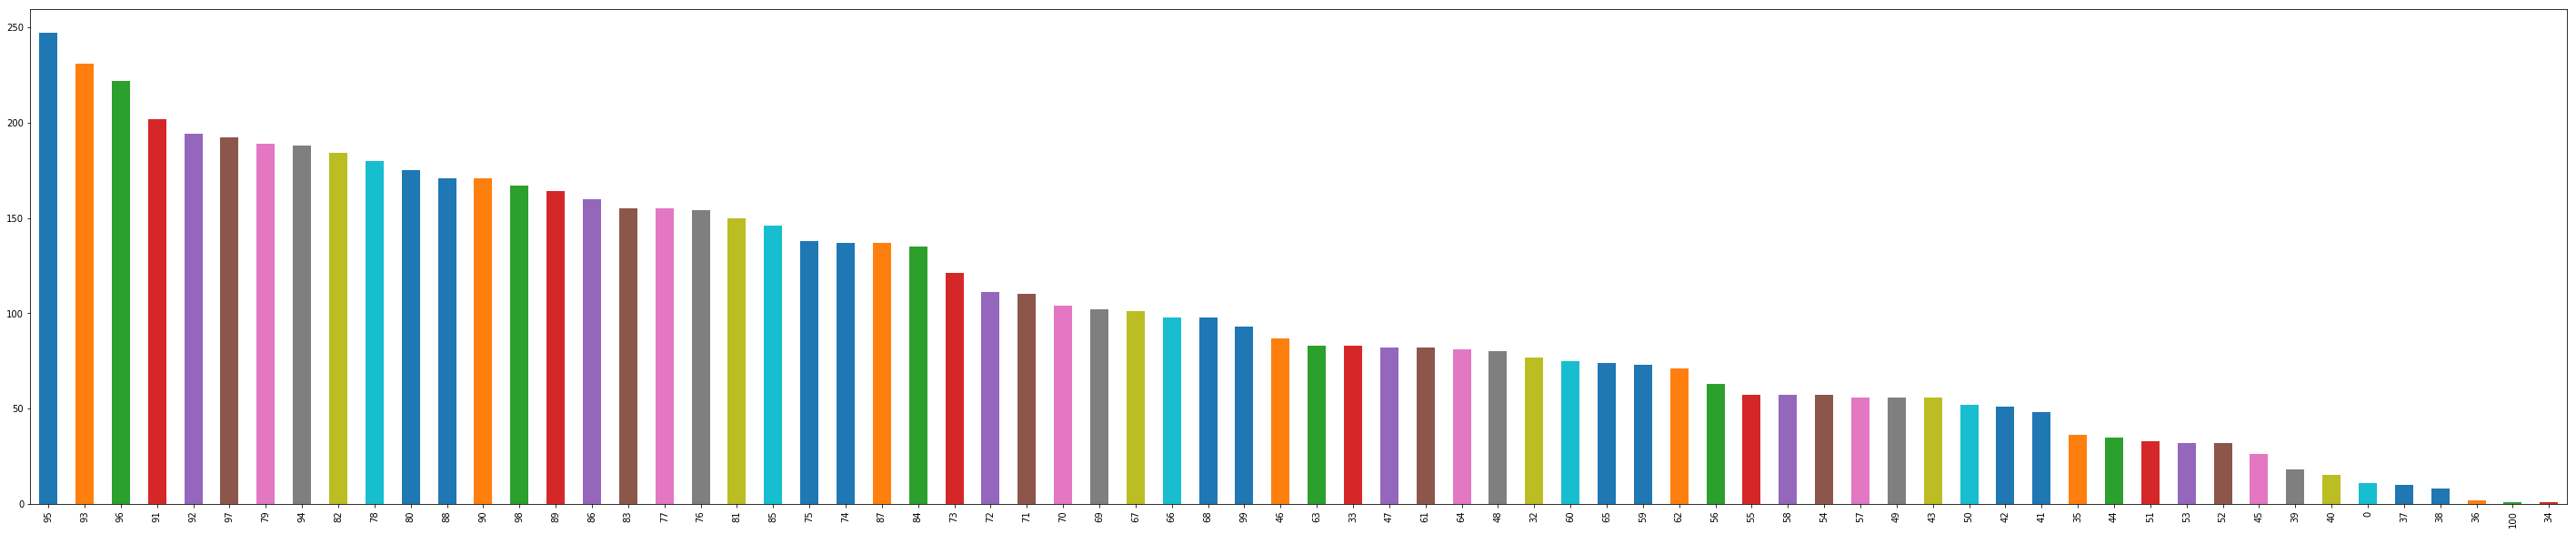

In [6]:
telco_dataset['TotalCharges'] = telco_dataset['TotalCharges'].apply(lambda x: 0 if x == 0 else math.log(x, 10)) 

# get bin width to divide into ranges
bin_width = float(telco_dataset['TotalCharges'].max() - telco_dataset['TotalCharges'].min())/100
a = telco_dataset['TotalCharges'].apply(lambda x: int(x/bin_width))
a.sort_values(ascending = True).value_counts().plot(kind="bar", figsize = (50, 10))


We now notice that we have four multi-categorical features - "Contract", "InternetService", "MultipleLines", and "PaymentMethod". In order to represent this, we can create a sparse vector for each feature using one-hot encoding. We do this using the Keras to_categorical function which takes as input a vector with n-categroical features and returns a sparse vector of length n where each index represents one category (1 being present, 0 not present). 

At first sight, this code may seem intimidating. All we are doing below is first creating vectors of categorical features such that each category is replaced by an integer. So for a feature with 3 categories, the vector will replace each corresponding category with an integer in [0, 2]. Then, we use the to_categorical function as described above. Finally, we just add this to our dataset.

In [7]:
from keras.utils import to_categorical

def one_hot_encoding(telco_dataset):
    # create vectors of categorical features from 0..n. 
    telco_dataset['Contract'] = telco_dataset['Contract'].map({'Month-to-month': 0, 'One year': 1, 
                                                    'Two year': 2}).astype(int)
    
    telco_dataset['InternetService'] = telco_dataset['InternetService'].map({'DSL': 0, 
                                                                             'Fiber optic': 1, 'No': 2}).astype(int)
    
    telco_dataset['MultipleLines'] = telco_dataset['MultipleLines'].map({'No': 0, 
                                                    'No phone service': 1, 'Yes': 2}).astype(int)
    
    telco_dataset['PaymentMethod'] = telco_dataset['PaymentMethod'].map({'Bank transfer (automatic)': 0, 
                                                    'Credit card (automatic)': 1, 
                                                    'Electronic check': 2, 
                                                    'Mailed check': 3}).astype(int)
    
    # create one-hot embedding
    payment_one_hot = to_categorical(telco_dataset['PaymentMethod'], 4)
    lines_one_hot = to_categorical(telco_dataset['MultipleLines'], 3)
    internet_one_hot = to_categorical(telco_dataset['InternetService'], 3)
    contract_one_hot = to_categorical(telco_dataset['Contract'], 3)
    tenure_one_hot = to_categorical(telco_dataset['tenure'], 6)
    payment_df = pd.DataFrame(payment_one_hot, columns=['Bank transfer (automatic)', 
                                                        'Credit card (automatic)', 
                                                        'Electronic check', 'Mailed check']).astype(int)
    
    
    # create new dataframe and join to telco_dataset
    lines_df = pd.DataFrame(lines_one_hot, columns=['No_lines', 'No phone service', 'Yes_lines']).astype(int)
    internet_df = pd.DataFrame(internet_one_hot, columns=['DSL', 'Fiber optic', 'No_internet']).astype(int)
    contract_df = pd.DataFrame(contract_one_hot, columns=['Month-to-month', 'One year', 'Two year']).astype(int)
    tenure_df = pd.DataFrame(tenure_one_hot, columns=['bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6']).astype(int)
    telco_dataset = telco_dataset.join(payment_df).join(lines_df).join(internet_df).join(contract_df).join(tenure_df)
    telco_dataset = telco_dataset.drop(['Contract', 'InternetService', 'MultipleLines', 'PaymentMethod', 'tenure'], axis = 1)
    return telco_dataset


Notice that the 'tenure' feature is continuous. It is common to discretize continuous features to improve network accuracy. To do this, we will split 'tenure' into 6 bins using the cut function which splits the feature into six ranges and puts all values in their specific buckets. We also replace true and false with 1 and 0. 

In [8]:
def replace_true_false(telco_dataset):
    telco_dataset.replace({'Yes': 1, 'No': 0, 'No internet service': 0}, inplace = True)
    return telco_dataset

def discretize_tenure(telco_dataset):
    # create cuts to discretize tenure
    telco_dataset['tenure'] = pd.cut(telco_dataset['tenure'], 6, labels = ['0', '1', '2', '3', '4', '5'])
    telco_dataset['tenure'] = pd.to_numeric(telco_dataset['tenure'])
    return telco_dataset

def replace_male_female(telco_dataset):
    telco_dataset.replace({'Male': 1, 'Female': 0}, inplace = True)
    return telco_dataset


Now we apply all our transformations to the telco_dataset.

In [9]:
# perform all pre-processing
telco_dataset = discretize_tenure(telco_dataset)
telco_dataset = one_hot_encoding(telco_dataset)
telco_dataset = replace_true_false(telco_dataset)
telco_dataset = replace_male_female(telco_dataset)
telco_dataset[1:10]

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,No_internet,Month-to-month,One year,Two year,bin1,bin2,bin3,bin4,bin5,bin6
1,1,0,0,0,1,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
2,1,0,0,0,1,1,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,1,0,0,0,0,1,0,1,1,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
5,0,0,0,0,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,0
6,1,0,0,1,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
7,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
8,0,0,1,0,1,0,0,1,1,1,...,0,1,0,0,0,0,1,0,0,0
9,1,0,0,1,1,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


Our dataset is now ready to be trained on. All we have to do is create a model.

### Creating a Neural Network 

Finally, we get to the bread and butter of Keras - creating models. At the heart of Keras is the core data structure model. There are two types of models - Sequential and Functional. Since this tutorial is meant to be an introduction to Keras, we will focus on the Sequential model. The Sequential model is a linear stack of layers in which each layer performs some transformation on its input. 

We assume that the reader understands Deep Neural Networks and the layers we use. To get a background about Deep Learning, we recommend that you read through this tutorial (http://adventuresinmachinelearning.com/neural-networks-tutorial/) before proceeding. 

In order to predict consumer churn, we will create an Artificial Neural Network with 5 layers - Dense, Dropout, Dense, Dropout, Dense. We use the dropout layers to prevent our model from overfitting the training data as dropout will deactivate a proporation of random nodes. 

To define this linear model in Keras, we will first instantiate a Sequential model and then add the necessary layers from the Keras.layers class using the model.add function. Keras.layers has most commonly used layers like - Convolution, Dense, Max Pooling etc. model.add just appends this layer on top of the previous layer in the model. Note that we only have to specify input_size in model.add when we are adding our first layer. For all other layers, Keras implicitly infers the size of its input.

In [10]:
from keras import Sequential
from keras.layers import Dense, Dropout

def create_ANN():
    model = Sequential()                                            # create sequential model
    model.add(Dense(16, activation = "relu", input_shape = (33,)))  # add layers
    model.add(Dropout(rate = 0.1))
    model.add(Dense(16, activation = "relu"))
    model.add(Dropout(rate = 0.1))
    model.add(Dense(1, activation="sigmoid"))                       # size is 1 since we have binary output
    return model

model = create_ANN()

Now that we have created our model, we can go ahead and visualize it using Keras' built-in visualizer. This is particularly useful when working with Deep Neural Nets with a large number of hidden layers. model.summary() gives a useful terse representation of the layers in the model with the type, shape and parameters defined. As you can see, the shape of all layers is implicitly infered by Keras. 

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


Sometimes, we need to understand how each layer connects to the next in order to study the network. For these cases, we can plot the model to reveal the connections between layers. 

To do this, we can use the Keras model_to_dot function which creates a PyDot.Graph type from our model. Then we can use SVG (Scalabale Vector Graphics) to render this Graph. 

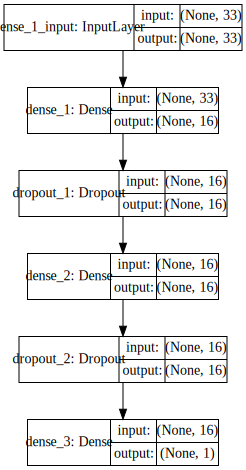

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# convert to graph object then render it using SVG
SVG(model_to_dot(model, show_shapes = True, show_layer_names = True).create(prog='dot', format='svg'))

### Training and Testing

To complete our Artificial Neural Network, we need to compile the model with a loss function. Since we are predicting 0-1 for Customer Churn, we will use binary crossentropy loss. We also provide as argument a list of metrics that we want the model to keep track of. compile also requires as input an optimizer - we will be using adam. 

Finally, we need to train our model on the dataset. To do this, we use the model.fit function provided in Keras. fit takes as argument a set of training features and corresponding outputs, batch_size for the number of examples processed at once and epochs to specify the duration of training. Keras also allows us to create a test set using the validation_split argument which splits the dataset into two sets in the given proportions. In our case, we will use 20% of examples to test. 

In [13]:
model.compile(loss='binary_crossentropy',
             optimizer = 'adam',
              metrics=['accuracy'])

xTrain = telco_dataset.drop("Churn", axis = 1)
yTrain = telco_dataset["Churn"]

history = model.fit(xTrain, yTrain, batch_size = 32, epochs = 20, validation_split = 0.2) # fit begins model training
# history contains loss and accuracy values at each epoch


Train on 5634 samples, validate on 1409 samples
Epoch 1/20
5634/5634 [==============================] - 1s 110us/step - loss: 1.0737 - acc: 0.6502 - val_loss: 0.5746 - val_acc: 0.7324
Epoch 2/20
5634/5634 [==============================] - 0s 52us/step - loss: 0.6735 - acc: 0.6988 - val_loss: 0.5141 - val_acc: 0.7296
Epoch 3/20
5634/5634 [==============================] - 0s 51us/step - loss: 0.5645 - acc: 0.7307 - val_loss: 0.4782 - val_acc: 0.7551
Epoch 4/20
5634/5634 [==============================] - 0s 53us/step - loss: 0.5067 - acc: 0.7481 - val_loss: 0.4526 - val_acc: 0.7963
Epoch 5/20
5634/5634 [==============================] - 0s 49us/step - loss: 0.4725 - acc: 0.7680 - val_loss: 0.4368 - val_acc: 0.8020
Epoch 6/20
5634/5634 [==============================] - 0s 50us/step - loss: 0.4626 - acc: 0.7836 - val_loss: 0.4331 - val_acc: 0.7991
Epoch 7/20
5634/5634 [==============================] - 0s 52us/step - loss: 0.4503 - acc: 0.7824 - val_loss: 0.4358 - val_acc: 0.7921
Epoch 

Hurrah! We achieve an accuracy of 80% on the validation set. As seen above, model.fit returns a history of training keeping track of the metrics provided (accuracy in this case). Now that we have introduced to creating models and visualizing them in Keras, lets move on to a slightly more involved example of classifying images.

## Example 2 - Classifying Images

It is often the case in Deep Learning that our dataset will consist of raw pixel data from images. In this part of the tutorial, we will see how Keras can be used to pre-process raw pixel data and create a Convolutional Neural Network for classification. 

### Data Collection

We will use the cifar10 dataset which consists of images belonging to 10 categories. Keras has a repsoitory of popular datasets which we can use to extract our training and test examples. To do this, we simply import the cifar10 dataset from keras.datasets and load the data into the appropriate arrays. Moreover, we can also import weights and models of popular Machine Learning models such as image-net using the Keras.applications Class. An example of this can be seen here - (https://keras.io/applications/#usage-examples-for-image-classification-models).


In [14]:
from keras.datasets import cifar10
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()  
yTrain = to_categorical(yTrain, 10)                    # one hot encoding
yTest = to_categorical(yTest, 10)                      # one hot encoding
xTrain = xTrain.astype('float32')           
xTest = xTest.astype('float32')
print(xTrain.shape, xTest.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


We notice that each image is of size (32, 32) with 3 channels for rgb. We have 50000 examples for our training data and 10000 for testing. 

### Image Pre-processing and Augmentation

In order to improve the accuracy of our results, we need more examples in the training set. We can add more examples by making transformations on the original raw-pixel data already in the training set and augmenting these to our training set. Keras has a very powerful Image Agumenter called ImageDataGenerator which allows users to make transformations on input images and add them to the training set. It is important to note that ImageDataGenerator does not apply transformations on images in memory; instead, it is an iterable which returns processed batches of images when requested. This reduces memory overhead but adds additional time during training.

We will use ImageDataGenerator to rotate, shift and flip images to augment more training examples. rotation_range provides a range within which to randomly rotate the image, width_shift_range and height_shift_range provide ranges within which to randomly shift the image and finally we use horizontal_flip to flip the image. This can be seen below.


In [70]:
from keras.preprocessing.image import ImageDataGenerator

image_data_generator = ImageDataGenerator(
        featurewise_center=False,             # normalize data such that mean is 0
        featurewise_std_normalization=False,  # divide by std of data
        rotation_range=0.1,                   # rotate randomly within specified range
        width_shift_range=0.1,                # shift width within specified range
        height_shift_range=0.1,               # shift height within specified range
        horizontal_flip=True,                 # flip horizontally
        vertical_flip=False,                  # shift vertically
        rescale = 1./255)                     # rescale to specified range


image_data_generator.fit(xTrain)

We have created our ImageDataGenerator. We don't need to apply this to our training set just yet! We will be doing that in real-time as we train our model. Now its time to create our Convolutional Neural Network (CNN). 

### Creating a CNN

We will create a CNN with a stack of 2 Convolution layers (kernel size 3x3) with RELU activation followed by Max Pooling (kernel size 2x2). We do this the same way as described before by instantiating a Sequential model and adding the necesssary layers. For the Convolution and Max Poolng layers, we need to specify the size of the kernel. 


In [31]:
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten

model = Sequential()                                                # instantiate Sequential model
model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu',   # add conv layer of kernel size (3x3), RELU
                 input_shape=xTrain[1].shape))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))                           # MaxPool with kernel size (2x2)
model.add(Dropout(0.25))                                            # dropout 25% of neurons
 
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

Now we add two fully connected layers on top of this model. 

In [32]:
model.add(Flatten())             # convert matrix to 1-D vector
model.add(Dense(512))            # fully connected layer with RELU activation 
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax')) # fully connected layer with Softmax activation

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
__________

### Training and Testing

Now we need to compile our model like before. However, this time we will use categorical cross-entropy loss since we are predicting multi-categorical output. We use rmsprop as the optimizer and set accuracy as the metric. All we need to do then is fit our model on the dataset using the Keras.fit_generator() function. We use fit_generator instead of fit because our images have not been transformed in memory but are being generated in real time as we train. We need to be careful here to not use xTrain and yTrain but instead apply our ImageDataGenerator on them. To do this, we use the ImageDataGenerator.flow() function which takes as input our dataset returns batches of transformed images when requested by the model. 

In [18]:
# compile the model with categorical cross-entropy loss and rmsprop optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


# train our model on real-time generated images from the imageDataGenerator
history = model.fit_generator(image_data_generator.flow(xTrain, yTrain, batch_size = 32), epochs = 20, 
                                        validation_data = (xTest, yTest)) 

Epoch 1/20
1563/1563 [==============================] - 173s 111ms/step - loss: 1.8751 - acc: 0.3116 - val_loss: 1.5756 - val_acc: 0.4312
Epoch 2/20
1563/1563 [==============================] - 167s 107ms/step - loss: 1.5804 - acc: 0.4210 - val_loss: 1.4125 - val_acc: 0.4873
Epoch 3/20
1563/1563 [==============================] - 183s 117ms/step - loss: 1.4692 - acc: 0.4670 - val_loss: 1.3201 - val_acc: 0.5256
Epoch 4/20
1563/1563 [==============================] - 171s 109ms/step - loss: 1.3861 - acc: 0.4997 - val_loss: 1.2174 - val_acc: 0.5670
Epoch 5/20
1563/1563 [==============================] - 168s 108ms/step - loss: 1.3122 - acc: 0.5331 - val_loss: 1.1744 - val_acc: 0.5831
Epoch 6/20
1563/1563 [==============================] - 170s 109ms/step - loss: 1.2538 - acc: 0.5513 - val_loss: 1.1387 - val_acc: 0.5949
Epoch 7/20
1563/1563 [==============================] - 180s 115ms/step - loss: 1.2030 - acc: 0.5729 - val_loss: 1.0439 - val_acc: 0.6276
Epoch 8/20
1563/1563 [============

### Visualizing Results

We can use the history returned from model.fit to plot training/testing accuracy/loss. We do this below.

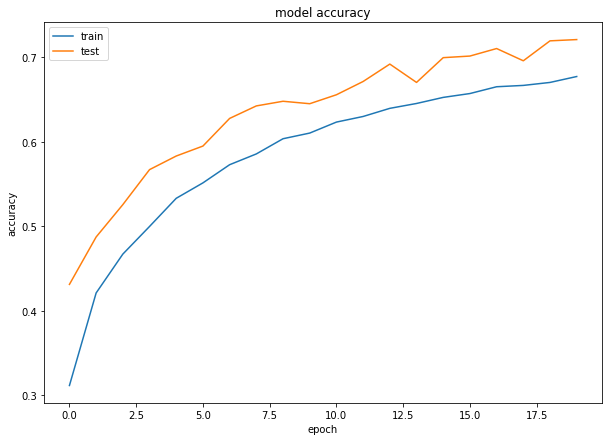

In [20]:
from keras.models import load_model

model.save('CNN.h5')  # creates a HDF5 file 'my_model.h5'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (10, 7))

plt.plot(history.history["acc"])              # training accuracy 
plt.plot(history.history["val_acc"])          # test accuracy
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

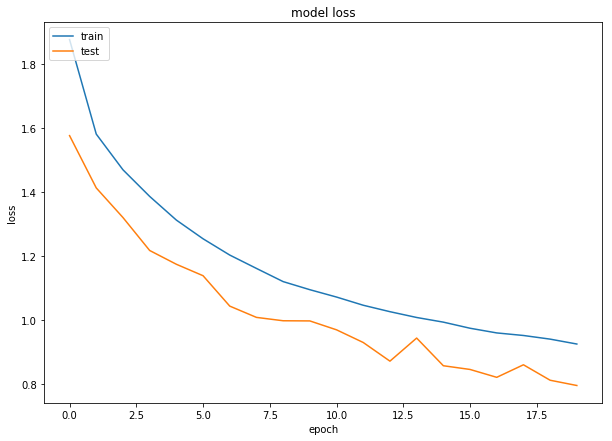

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (10, 7))

plt.plot(history.history["loss"])           # training loss
plt.plot(history.history["val_loss"])       # test loss
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We achieved 70% accuracy trying to classify images into 10 labels. We can further improve our accuracy by fine-tuning our model. Fine-tuning is a process in which lower parts of the network are trained on a large dataset to extract generic features and then we train the top layers to learn dataset specific features. A great example of this can be found here - (https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975).


## Final Thoughts about Keras

We have seen how Keras can be used to create models using layers as building blocks with the Sequential model Class. We recommend that you read this guide (https://keras.io/getting-started/functional-api-guide/) about the Functional Model. It builds on top of the Sequential model allowing you to create more intricate models.  

In essense, we have seen how Keras can be used to implement end-to-end Deep Learning Pipelines from data collection, pre-processing and augmentation, model creation and classification to visualization with ease and very little code. 